# Modelagem preditiva

Neste notebook vamos estudar a predição do sinal (alta ou baixa) do preço de uma ação (AMZN)

Faremos aqui uma modelagem categórica e utilizaremos os modelos de regressão logística e XGBoost.



#### Setup inicial

Instalação de Pacotes

In [1]:
# !pip install "yfinance==0.2.65" "pandas<2.0.0" "numpy<2.0.0" "scikit-learn==1.7.1" "xgboost==3.0.2" "matplotlib==3.10.3" "ipython==9.4.0" "jupyterlab==4.4.5" "seaborn==0.13.2"

Imports

In [2]:
import warnings


import yfinance as yf
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import (
    accuracy_score,
    classification_report,
)
import matplotlib.pyplot as plt

Configurações iniciais

In [3]:
warnings.filterwarnings("ignore")

## Etapa 1: Baixar dados da Amazon

In [4]:
df = yf.download('^BVSP', period='10y', interval='1d')
df.columns

[*********************100%***********************]  1 of 1 completed


MultiIndex([( 'Close', '^BVSP'),
            (  'High', '^BVSP'),
            (   'Low', '^BVSP'),
            (  'Open', '^BVSP'),
            ('Volume', '^BVSP')],
           names=['Price', 'Ticker'])

In [5]:
df

Price,Close,High,Low,Open,Volume
Ticker,^BVSP,^BVSP,^BVSP,^BVSP,^BVSP
Date,,,,,
2015-08-03,50138.0,50867.0,50054.0,50867.0,2613200
2015-08-04,50058.0,50574.0,49827.0,50138.0,2670400
2015-08-05,50287.0,50853.0,50067.0,50067.0,2662100
2015-08-06,50011.0,50534.0,49624.0,50280.0,3640800
2015-08-07,48577.0,50013.0,48512.0,50013.0,3218400
...,...,...,...,...,...
2025-07-28,132129.0,133902.0,131550.0,133538.0,6625600
2025-07-29,132726.0,133346.0,132130.0,132130.0,6324800


In [6]:
df = df[['Close', "High", "Low", "Open", "Volume"]].dropna().reset_index()
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df_model = df.dropna().copy()
df_model

,Date,Close,High,Low,Open,Volume
0,2015-08-03,50138.0,50867.0,50054.0,50867.0,2613200
1,2015-08-04,50058.0,50574.0,49827.0,50138.0,2670400
2,2015-08-05,50287.0,50853.0,50067.0,50067.0,2662100
3,2015-08-06,50011.0,50534.0,49624.0,50280.0,3640800
4,2015-08-07,48577.0,50013.0,48512.0,50013.0,3218400
...,...,...,...,...,...,...
2476,2025-07-28,132129.0,133902.0,131550.0,133538.0,6625600
2477,2025-07-29,132726.0,133346.0,132130.0,132130.0,6324800
2478,2025-07-30,133990.0,134368.0,131883.0,132702.0,8655300
2479,2025-07-31,133071.0,133987.0,132096.0,133987.0,9196800


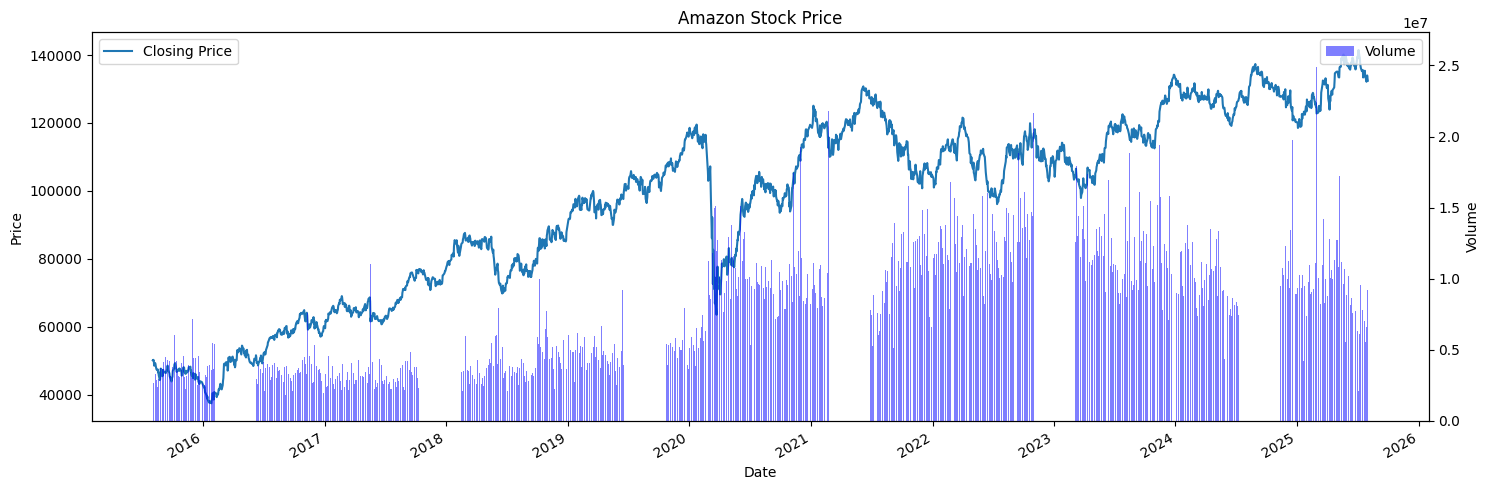

In [7]:
ax = df.plot(x='Date', y='Close', kind='line', label='Closing Price')
ax.set_title('Amazon Stock Price')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
fig = ax.get_figure()
fig.set_figwidth(15)
fig.set_figheight(5)


# add the volume as a bar chart with a secondary y-axis
ax2 = ax.twinx()
ax2.bar(df['Date'], df['Volume'], alpha=0.5, color='blue', label='Volume')
ax2.set_ylabel('Volume')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()

## Etapa 2: Criando features e target

In [8]:
dataset = pd.DataFrame()

In [9]:
dataset["Close"] = df["Close"]

delta = df['Close'].diff()
dataset["Delta"] = delta.shift(1)

threshold = 0.005  # desconsiderando variações menores que 0.5%
dataset['Target'] = np.where(
    delta > threshold, 1, np.where(delta < -threshold, 0, np.nan)
)

Podemos utilizar o retorno dos dias anteriores para prever o retorno do dia atual.

In [10]:
dataset['Return'] = dataset['Close'].pct_change().shift(1)

Podemos criar N lags de 1 a N

In [11]:
def make_lags(series: pd.Series, n_lags):
    return series.shift(n_lags)


def make_n_lags(df, n_lags, column):
    for i in range(1, n_lags + 1):
        df[f"{column}_lag{i}"] = df[column].shift(i)
    return df

In [12]:
# vamos criar N lags de 1 a N
n_lags = 10

# drop after the lags are created
dataset = make_n_lags(dataset, n_lags, 'Target')

Os dados de máxima e mínima não podem ser utilizados para prever o preço do fechamento dentro do mesmo dia, porém podemos utilizá-los para prever o preço de fechamento do dia seguinte.

In [13]:
dataset["High"] = df["High"].shift(1)
dataset["Low"] = df["Low"].shift(1)

Vamos também considerar o intervalo de variação diário do preço de fechamento.

In [14]:
dataset["Volatilidade"] = df["High"] - df["Low"]
dataset["Volatilidade_relativa"] = dataset["Volatilidade"] / dataset["Low"]

O dado de abertura é o primeiro dado de cada dia, logo podemos utilizá-lo com segurança.

In [15]:
dataset["Open"] = df["Open"]

Vamos também utilizar dados de médias móveis, para diferentes janelas de tempo.

In [16]:
# 1 semana útil = 5 dias
df['MA5'] = df['Close'].rolling(window=5).mean().shift(1)

# 1 mês útil = 22 dias
df['MA22'] = df['Close'].rolling(window=22).mean().shift(1)

# 3 meses úteis (trimestre)
df['MA66'] = df['Close'].rolling(window=66).mean().shift(1)

# 6 meses úteis (semestre)
df['MA132'] = df['Close'].rolling(window=132).mean().shift(1)

# 1 ano útil = 252 dias
df['MA252'] = df['Close'].rolling(window=252).mean().shift(1)

In [17]:
dataset.drop("Close", axis=1, inplace=True)
df_model = dataset.dropna().copy()
df_model

,Delta,Target,Return,Target_lag1,Target_lag2,Target_lag3,Target_lag4,Target_lag5,Target_lag6,Target_lag7,Target_lag8,Target_lag9,Target_lag10,High,Low,Volatilidade,Volatilidade_relativa,Open
11,-291.0,1.0,-0.006125,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,47788.0,47217.0,1408.0,0.029820,47220.0
12,234.0,0.0,0.004956,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,48084.0,46676.0,1474.0,0.031579,47451.0
13,-863.0,1.0,-0.018187,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,47451.0,45977.0,751.0,0.016334,46588.0
14,61.0,0.0,0.001309,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,46781.0,46030.0,972.0,0.021117,46649.0
15,-929.0,0.0,-0.019915,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,46649.0,45677.0,2966.0,0.064934,45715.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2476,-284.0,0.0,-0.002122,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,134204.0,133285.0,2352.0,0.017646,133538.0
2477,-1395.0,1.0,-0.010448,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,133902.0,131550.0,1216.0,0.009244,132130.0
2478,597.0,1.0,0.004518,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,133346.0,132130.0,2485.0,0.018807,132702.0
2479,1264.0,0.0,0.009523,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,134368.0,131883.0,1891.0,0.014338,133987.0


## Etapa 3: Separar treino e teste

In [18]:
# utilizando os últimos 30 dias como teste
train = df_model.iloc[:-30]
test = df_model.iloc[-30:]

predictors = list(train.columns)
predictors.remove('Target')

X_train, X_test = train[predictors], test[predictors]
y_train, y_test = train['Target'], test['Target']

## Etapa 4: Pipelines

In [19]:
tscv = TimeSeriesSplit(n_splits=5)

### Pipeline e GridSearch para Regressão Logística

In [20]:
pipe_lr = Pipeline(
    [('scaler', StandardScaler()), ('clf', LogisticRegression(solver='liblinear'))]
)

param_grid_lr = {
    'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],  # regularização
    'clf__penalty': ['l1', 'l2'],  # tipo de penalização
    'clf__solver': ['liblinear'],  # necessário para suportar l1
}

grid_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=tscv)
grid_lr.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid={'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'clf__penalty': ['l1', 'l2'],
                         'clf__solver': ['liblinear']})

### Pipeline e GridSearch para XGBoost

In [21]:
pipe_xgb = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('clf', XGBClassifier()),
    ]
)

param_grid_xgb = {
    'clf__n_estimators': [50, 100, 200],  # número de árvores
    'clf__max_depth': [3, 5, 7],  # profundidade da árvore
    'clf__learning_rate': [0.01, 0.05, 0.1, 0.3],  # taxa de aprendizado
    'clf__subsample': [0.6, 0.8, 1.0],  # fração das amostras usadas em cada árvore
    'clf__colsample_bytree': [0.6, 0.8, 1.0],  # fração de colunas usadas por árvore
    'clf__gamma': [0, 0.1, 0.5, 1.0],  # regularização mínima para divisão
    'clf__reg_alpha': [0, 0.1, 1],  # L1 regularization
    'clf__reg_lambda': [0.1, 1, 10],  # L2 regularization
}

grid_xgb = RandomizedSearchCV(pipe_xgb, param_grid_xgb, cv=tscv)
grid_xgb.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('clf',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metr...
                                                            multi_strategy=None,
                                                            n_estimators=None,
                                                            n_jobs=None,
                                                            num_parallel_tree=None, ...))]),
                   param_distributions={'clf__colsample_bytree': [0.6, 0.8,
                                                                  1.0],
                                        'clf__gamma': [0, 0.1, 0.5, 1.0],
                                        'clf__learning_rate': [0.01, 0.05, 0.1,
                                                               0.3],
                                        'clf__max_depth': [3, 5, 7],
                                        'clf__n_estimators': [50, 100, 200],
                                        'clf__reg_alpha': [0, 0.1, 1],
                                        'clf__reg_lambda': [0.1, 1, 10],
                                        'clf__subsample': [0.6, 0.8, 1.0]})

## Etapa 5: Avaliação dos modelos

In [22]:
print("Logistic Regression:")
print("Melhores parâmetros:", grid_lr.best_params_)
print("Acurácia:", accuracy_score(y_test, grid_lr.predict(X_test)))
print(classification_report(y_test, grid_lr.predict(X_test)))

Logistic Regression:
Melhores parâmetros: {'clf__C': 100, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Acurácia: 0.36666666666666664
              precision    recall  f1-score   support

         0.0       0.45      0.28      0.34        18
         1.0       0.32      0.50      0.39        12

    accuracy                           0.37        30
   macro avg       0.39      0.39      0.37        30
weighted avg       0.40      0.37      0.36        30



In [23]:
print("\nXGBoost:")
print("Melhores parâmetros:", grid_xgb.best_params_)
print("Acurácia:", accuracy_score(y_test, grid_xgb.predict(X_test)))
print(classification_report(y_test, grid_xgb.predict(X_test)))


XGBoost:
Melhores parâmetros: {'clf__subsample': 0.6, 'clf__reg_lambda': 10, 'clf__reg_alpha': 0, 'clf__n_estimators': 50, 'clf__max_depth': 7, 'clf__learning_rate': 0.01, 'clf__gamma': 0, 'clf__colsample_bytree': 0.8}
Acurácia: 0.5
              precision    recall  f1-score   support

         0.0       0.67      0.33      0.44        18
         1.0       0.43      0.75      0.55        12

    accuracy                           0.50        30
   macro avg       0.55      0.54      0.49        30
weighted avg       0.57      0.50      0.48        30



### Comparação com um modelo baseline

Vamos comparar com um modelo básico, que apenas repete a última observação

In [24]:
baseline_pred = y_test.shift(1).diff().dropna().apply(np.sign) + 1

# calculando a acurácia do baseline
baseline_accuracy = accuracy_score(y_test.loc[baseline_pred.index], baseline_pred)
print(f"Acurácia do baseline: {baseline_accuracy:.2f}")

Acurácia do baseline: 0.18


In [25]:
# acurácia dos modelos

# regressão logística
log_reg_accuracy = accuracy_score(y_test, grid_lr.predict(X_test))

# xgboost
xgb_accuracy = accuracy_score(y_test, grid_xgb.predict(X_test))

# criando a tabela de comparação
tabela_comparativa = pd.DataFrame(columns=['Modelo', 'Acurácia'])

tabela_comparativa.loc[0] = ['Baseline', f"{baseline_accuracy*100:.2f}%"]
tabela_comparativa.loc[1] = ['Logistic Regression', f"{log_reg_accuracy*100:.2f}%"]
tabela_comparativa.loc[2] = ['XGBoost', f"{xgb_accuracy*100:.2f}%"]

tabela_comparativa

,Modelo,Acurácia
0,Baseline,17.86%
1,Logistic Regression,36.67%
2,XGBoost,50.00%
